<br />

<h1 align="center">Data Ingestion Prep</h1>
<h5 align="center">for</h5>
<h1 align="center">Asisa Flows</h1>
<h5 align="center">by</h5>
<h3 align="center">Monde Anna</h3>

<br />
<br />


<h2 align="center">Introduction</h2>

<br />
<br />


<p><a href="https://www.asisa.org.za/about-us/"><b><i>ASISA</i></b></a> is a non-profit organisation that represents South Africa's financial services sector. In essence, offering a union, wherein membership gives companies in the savings, investment and insurance industries a combined voice in discussions and negotiations with regulators, policymakers and other stakeholders, such as intermediaries, the media and consumers.</p>

<p>To our great benefit, <b><i>ASISA</i></b> also provides <a href="https://www.asisa.org.za/statistics/">statistics</a> relating to the financial services sector and it is with those that we will concern ourselves.</p>

<p>The task ahead of us is preparing <i>Analysis</i> and <i>CISFunds</i> sheets data, published in <i>Flows</i> documentation, for ingestion and to do so for any available quarter. To our great joy, the source data is already in a flat state and merely misses quarterly dates. Concerning <i>CISFunds</i>, there are years without data, a point to remain cognizant of. For more information on <b><i>ASISA</i></b>, please follow this <a href="https://www.asisa.org.za/about-us/">link</a>.</p>

<p>We will use the Start Schema with a <b><i>Fact</i></b> that links to the <b><i>Dimensions</i></b> below:</p>

<br />

<table align="center">
    <tr>
        <th align="center" colspan="5"><b><i>Dimensions</i></b></th>
    </tr>
    <tr>
        <td align="center"><b><i>CIS_Manager</i></b></td>
        <td align="center"><b><i>Date_Key</i></b></td>
        <td align="center"><b><i>Sector_Classification</i></b></td>
        <td align="center"><b><i>Fund_Name</i></b></td>
        <td align="center"><b><i>Retail_Institutional</i></b></td>
    <tr>
        <td align="center"><b><i>Fund_of_Funds</i></b></td>
        <td align="center"><b><i>Third_Party</i></b></td>
        <td align="center"><b><i>Management_Style</i></b></td>
        <td align="center"><b><i>Original_Analysis</i></b></td>
        <td align="center"><b><i>Original_CIS_Funds</i></b></td>
    </tr>
</table>


<br />

<p><b><i>NOTE:</i></b> <a href="https://www.sqlshack.com/implementing-slowly-changing-dimensions-scds-in-data-warehouses/">Slowly Changing Dimensions</a> will be handled using SDC Type 1, that is, overwritten.</p>

<br />
<br />


<h2 align="center">Imports</h2>

<br />
<br />


In [1]:
from utilities.preprocessing import run_preprocessing
from utilities.data_explorer import FlowDataExplorer
from utilities.data_cleaner import AnalysisCleaner
from utilities.data_cleaner import CISFundsCleaner
from utilities.star_schema import FlowStarSchema
from utilities.asisa_scraper import scrape_excel
import pandas as pd


<br />

<h2 align="center">Global Settings</h2>

<br />
<br />


In [2]:
%%capture
%load_ext black_nb
pd.options.display.float_format = "{:.0f}".format


<br />

<h2 align="center">Data Acquisition</h2>

<br />
<br />


<p>Regarding published data, the <b><i>Asisa Web Scraper</i></b> module has the functionality that will take care of the acquisition. We will merely need to further clean the raw data and ensure that it is ready for presentation. As a way to limit the number of web calls, the returned <i>data</i> is stored in memory using Jupyter Notebook's <i>%store</i> magic method.</p>

<br />
<br />


<h5 align="center">In Memory Storage of Raw Data</h5>
<h5 align="center">Acquired via WebScraping</h5>

<br />
<br />


In [3]:
%%capture
%store -r excel_files

if "excel_files" not in globals():
    excel_files = scrape_excel("flow")
    %store excel_files


<br />

<h2 align="center">Preprocessing</h2>

<br />
<br />



<p>After <b><i>Preprocessing</i></b>, a majority of the work need to pretty up the data will be performed. Of primary interest is getting all sheets for <i>Analysis</i> into a single data frame, the same applies to <i>CIS Funds</i>. To limit having to perform similar tasks between exploring the data and actually cleaning it, a few matters will be made uniform, including, but not limited to, using <b><i>Date_Keys</i></b> as indexes, using title-cased <b><i>Feature Names</i></b> along with using underscore in place of whitespace therein.</p>

<p>This allows us to easily jump around the data with little effort. To our great luck, the <b><i>Preprocessing</i></b> also provides a script that simplifies this process. As with the acquisition process, <i>data</i>, having undergone <i>preprocessing</i> is stored in memory using Jupyter Notebook's <i>%store</i> magic method for the sake of convenience.</p>

<br />
<br />


In [4]:
%%capture
%store -r analysis_std cis_funds_std

if "analysis_std" not in globals():
    desired_sheets = {"Analysis": 0, "CISFunds": 2}
    analysis_std, cis_funds_std = run_preprocessing(excel_files, **desired_sheets)

    assert len(cis_funds_std) < len(analysis_std)
    %store analysis_std cis_funds_std


<br />

<h2 align="center">Data Exploration</h2>

<br />
<br />


<p>The <b><i>FlowsDataExplorer</i></b>, as with the web scraper, conveniently takes care of backend activities  for us, allowing for focus and discussion to be directed towards the state of the data. As a summary of what is to follow; matters arise due to misalignments between the raw <i>Analysis</i> and <i>CISFunds</i> data, note however that the majority of the concerns arise from the <i>CISFunds</i> data.</p>

<br />
<br />


In [5]:
desired_cis_funds_features = [
    "Fund_Code",
    "Fund_Name",
    "Sector_Code",
    "Sector_Classification",
]

data_explorer = FlowDataExplorer(
    analysis_std,
    cis_funds_std[desired_cis_funds_features],
)


<br />

<h5 align="center">Number of Quarters Containing Data</h5>

<br />
<br />


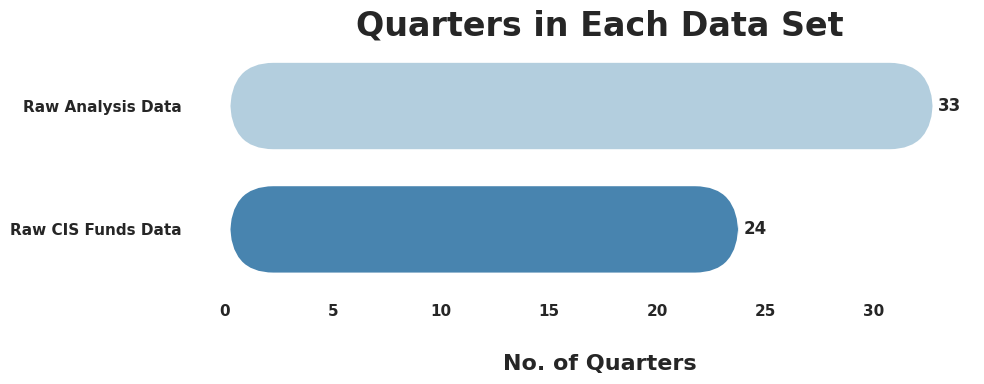

In [6]:
data_explorer.plot_number_of_quarters()


<br />

<table align="center">
    <th align="center" colspan="3">Quarters Without CIS Funds</th>
    <tr>
        <td><b><i>31<sup>st</sup> March 2015</i></b></td>
        <td><b><i>30<sup>th</sup> June 2015</i></b></td>
        <td><b><i>30<sup>th</sup> September 2015</i></b></td>
    </tr>
    <tr>
        <td><b><i>31<sup>st</sup> December 2015</i></b></td>
        <td><b><i>31<sup>st</sup> March 2016</i></b></td>
        <td><b><i>30<sup>th</sup> June 2016</i></b></td>
    </tr>
    <tr>
        <td><b><i>30<sup>th</sup> September 2016</i></b></td>
        <td><b><i>31<sup>st</sup> December 2016</i></b></td>
        <td><b><i>31<sup>st</sup> March 2017</i></b></td>
    </tr>
</table>

<br />
<br />


<h5 align="center">Observations</h5>

<br />

<ul>
    <li><b><i>CIS Funds</i></b> has <b><i>nine quarters</i></b> of missing data, equating to roughly <b><i>two years</i></b> of reports</li>
    <br />
    <li>Tabled above are quarters without <b><i>CISFunds</i></b> data</li>
    <br />
    <li>During data acquisition, an error log is kept of such quarters and it is from this log that the data have been sourced</li>
</ul>

<br />
<br />


<h3 align="center">Example of Analysis File in Raw State</h3>
<h5 align="center">Quarter Ending: 31<sup>st</sup> December 2018</h5>

<br />
<br />


In [7]:
data_explorer.sample_of_analysis(date_key=20181231)


,CIS_Manager,Geography,Allocation,Portfolio,Sector_Classification,Fund_Name,Retail_Institutional,Third_Party
Date_Key,,,,,,,,
20181231,ABSA,SOUTH AFRICAN,MULTI ASSET,LOW EQUITY,SOUTH AFRICAN – MULTI ASSET – LOW EQUITY,ABSA ABSOLUTE FUND,R,NAN
20181231,ABSA,REGIONAL,EQUITY,GENERAL,REGIONAL – EQUITY – GENERAL,ABSA AFRICA EQUITY FEEDER FUND,R,NAN
20181231,ABSA,SOUTH AFRICAN,MULTI ASSET,MEDIUM EQUITY,SOUTH AFRICAN – MULTI ASSET – MEDIUM EQUITY,ABSA BALANCED FUND,R,NAN
20181231,ABSA,SOUTH AFRICAN,INTEREST BEARING,VARIABLE TERM,SOUTH AFRICAN – INTEREST BEARING – VARIABLE TERM,ABSA BOND FUND,R,NAN
20181231,ABSA,SOUTH AFRICAN,INTEREST BEARING,VARIABLE TERM,SOUTH AFRICAN – INTEREST BEARING – VARIABLE TERM,ABSA BOND INDEX FUND,R,NAN


<br />

<h5 align="center">Observations</h5>

<br />

<ul>
    <li>We find that we have inconsistent casing throughtout the feature values, this is of particular concern as we do not want to alter the data types as of yet</li>
    <br />
    <li>Feature name casing is standardised</li>
    <br />
    <li>As illustrated by <b><i>Third Party</i></b>, we need to keep an eye out for null values</li>
</ul>

<br />
<br />


<h3 align="center">Example of Newer CIS Funds File in Raw State</h3>
<h5 align="center">Quarter Ending: 30<sup>th</sup> June 2021</h5>

<br />
<br />


In [8]:
cis_funds_std.loc[20210630].iloc[:5, :8]


,Fund_Code,Fund_Name,Sector_Code,Sector_Classification,Fund_Type,Fund_of_Funds,Third_Party_Fund,Third_Party_Manager
Date_Key,,,,,,,,
20210630,10XDA,10X DEFENSIVE INDEX FUND,DAPI,SOUTH AFRICAN – MULTI ASSET – INCOME,RETAIL,NO,NO,NAN
20210630,10XHA,10X HIGH EQUITY INDEX FUND,DAPV,SOUTH AFRICAN – MULTI ASSET – HIGH EQUITY,RETAIL,NO,NO,NAN
20210630,10XLA,10X LOW EQUITY INDEX FUND,DAPL,SOUTH AFRICAN – MULTI ASSET – LOW EQUITY,RETAIL,NO,NO,NAN
20210630,10XMA,10X MEDIUM EQUITY INDEX FUND,DAPM,SOUTH AFRICAN – MULTI ASSET – MEDIUM EQUITY,RETAIL,NO,NO,NAN
20210630,1NEFB1,1NVEST ENHANCED CORE EQUITY FUND,DEGN,SOUTH AFRICAN – EQUITY – GENERAL,RETAIL,NO,NO,NAN


<br />

<h5 align="center">Observations</h5>

<br />

<ul>
    <li>Feature naming and cell values are similar to <b><i>Analysis</i></b></li>
    <br />
    <li>As with the <b><i>Analysis</i></b> data, we have to look out for null values, as evidence, draw your eye to the <b><i>Third Party Manager</i></b> feature</li>
    <br />
    <li>Of particular concern two us are two groupings:
        <ul>
            <li><b><i>Group A:</i></b> <i>Fund Code</i> and <i>Fund Name</i>; and</li>
            <li><b><i>Group B:</i></b> <i>Sector Code</i> and <i>Sector Classification</i></li>
        </ul>
    </li>
    <br />
    <li>The above will play a useful role in ensuring that <b><i>Analysis</i></b> data accounts for changes in <b><i>Fund Names</i></b> as well as the evolution of <b><i>Sector Classifications</i></b></li>
</ul>

<br />
<br />


<h3 align="center">Inconsistencies Between Source Data</h3>
<h5 align="center">Unequal Value Counts</h5>

<br />
<br />


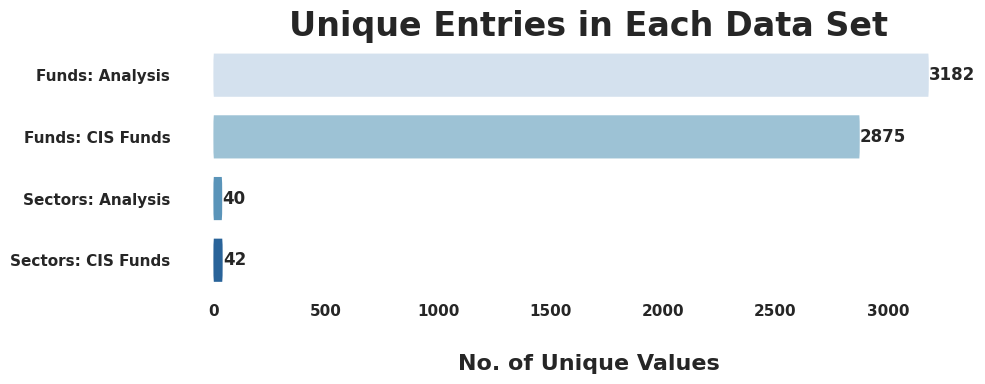

In [9]:
data_explorer.plot_value_counts()


<br />

<h5 align="center">Observation</h5>

<br />

<ul>
    <li>Data sourced from the <b><i>Analysis</i></b> sheets have more unique entries than that sourced from <b><i>CIS Funds</i></b> sheets</li>
    <br />
    <li><b><i>Sector Classification</i></b> Looks to have faired well with but a difference of <b><i>one</i></b></li>
    <br />
    <li>Of alarm is how <b><i>Fund Names</i></b> data has just above <b><i>800</i></b> more unique entries for <b><i>Analysis</i></b> over that of <b><i>CIS Funds</i></b>
        <ol>
            <li>Perhaps this is the result of there being no <b><i>CIS Funds</i></b> data in earlier source data</li>
            <br />
            <li>Likewise, this may be the effect of the transfer of asset management between companies, such as the <b><i><a href="https://www.moonstone.co.za/sanlam-absa-asset-management-transaction-concluded/#:~:text=The%20deal%20enhances%20Sanlam's%20position,largest%20black%2Downed%20asset%20managers.&text=The%20transaction%20sees%20Absa%20exchanging,Holdings%20Proprietary%20Limited%20(SIH)">ABSA-Sanlam Asset Management Transaction</a></i></b>. A selection from the linked transaction:
                <ul>
                    <li><b><i><a href="https://www.etfsa.co.za/Factsheets/absa%20-%20newfunds%20traci%20-%20jun2020.pdf">NewFunds TRACI 3 Month ETF</a></i></b>; now named</li>
                    <li><b><i><a href="https://satrix.co.za/products/product-details?id=91">Satrix TRACI - ETF</a></i></b></li>
                </ul>
            </li>
            <br />
            <li>Though speculative, this may be evidence of there having been an increase in the number of registered public funds, from <i>Meyers (2019)</i>:
                <ul>
                    <li><i>Fund closures ... for the CIS
industry with 86 closures in 2017 and 87 in 2018. The six months in 2019 saw 45
closures which had exceeded the number of new funds introduced to the market</i></li>
                    <li>Recall that closed funds are at times also merged into new and existing funds as quoted later</li>
                </ul>
            </li>
            <br />
            <li>Regardless, I anticipate a multitude of null values when mapping <b><i>Fund Codes</i></b> in the <b><i>Fund Name Dimension</i></b>, and so too with <b><i>Sector Classification</i></b></li>
        </ol>
    </li>
    <br />
    <li>As a separate note, keep in mind that the difference in the number of <b><i>Fund Names</i></b> does not immediately denote the number of closed funds, which in turn may add to the pool of total funds – consider, as described on page 2 of the linked <a href="https://repository.up.ac.za/bitstream/handle/2263/73989/Meyer_Survivor_2019.pdf?sequence=1">Survivorship Bias</a> study (Meyer, 2019):
        <ul>
            <li><i>The underperforming unit trusts struggle to maintain their investment mandate and the manager would generally rather liquidate the assets held in the fund or merge the remaining capital in better performing funds elsewhere in the business</i></li>
        </ul>
    </li>
</ul>

<br />
<br />


<h3 align="center">Inconsistencies in CIS Funds Source Data</h3>
<h5 align="center">Concatenated Entries</h5>

<br />
<br />


<p><b><i>Sector Code</i></b>, found in the <b><i>CIS Funds</i></b> data, looks to have cases wherein entries <i>(rows)</i> are merged. From what follows, please note how the other cells have had their values concatenated, such as the <b><i>Fund Code</i></b> <i>STFMB1STMFB1</i>. What follows are <b><i>Sector Codes</i></b> that are not four characters long; a deviation from the norm.</p>

<br />
<br />


In [10]:
data_explorer.inconsistent_sector_code_format().iloc[:-1]


,Fund_Code,Fund_Name,Sector_Code,Sector_Classification
Date_Key,,,,
20221231,PIFPOIF,PRESCIENT INCOME FUNDPRESCIENT INCOME FUND,DAPIDAFL,SOUTH AFRICAN – MULTI ASSET – INCOMESOUTH AFRI...
20220930,PIFPOIF,PRESCIENT INCOME FUNDPRESCIENT INCOME FUND,DAPIDAFL,SOUTH AFRICAN – MULTI ASSET – INCOMESOUTH AFRI...
20220331,STFMB1STMFB1,MELVILLE DOUGLAS STANLIB SA EQUITY FUNDMELVILL...,DEGNDEGN,SOUTH AFRICAN – EQUITY – GENERALSOUTH AFRICAN ...
20210630,BBGBFABGEQFA,BRENTHURST BCI GLOBAL BALANCED FEEDER FUNDBREN...,GAPHFEGN,GLOBAL – MULTI ASSET – HIGH EQUITYGLOBAL – EQU...
20210331,BBGBFABGEQFA,BRENTHURST BCI GLOBAL BALANCED FEEDER FUNDBREN...,GAPHFEGN,GLOBAL – MULTI ASSET – HIGH EQUITYGLOBAL – EQU...
20200930,GCIFASMGBFS,CINNABAR SANLAM COLLECTIVE INVESTMENTS INCOME ...,DAPIDAPM,SOUTH AFRICAN – MULTI ASSET – INCOMESOUTH AFRI...


<br />

<h5 align="center">Observations</h5>

<br />

<ul>
    <li><b><i>Reminder:</i></b> The majority of <b><i>Sector Codes</i></b> in the <b><i>CIS Funds</i></b> data are four characters long</li>
    <br />
    <li>We have observed four unique cases wherein <b><i>Sector Codes</i></b> are eight characters long:
        <ul>
            <li><b><i>DAPIDAFL</i></b> which is mapped to <b><i>South African – Multi Asset – IncomeSouth African – Multi Asset – Flexible</i></b></li>
            <li><b><i>DAPIDAPM</i></b> which is mapped to <b><i>South African – Multi Asset – IncomeSouth African – Multi Asset – Medium Equity</i></b></li>
            <li><b><i>DEGNDEGN</i></b> which is mapped to <b><i>South African – Equity – GeneralSouth African – Equity – General</i></b></li>
            <li><b><i>GAPHFEGN</i></b> which is mapped to <b><i>Global – Multi Asset – High EquityGlobal – Equity – General</i></b></li>
        </ul>
    </li>
    <br />
    <li>Individuated instances of these exist, meaning that these can possibly be dropped during <b><i>Data Cleaning</i></b></li>
    <br />
    <li>Coincidentally, <b><i>Fund Name</i></b> to shows a case of concatenated values, specificity being:
        <ol>
            <li><b><i>Prescient</i></b>
                <ul>
                    <li><b><i>Fund Code:</i></b>&emsp;&nbsp;PIFPOIF</li>
                    <li><b><i>Fund Name:</i></b>&emsp;Prescient Income FundPrescient Income Fund</li>
                    <li><b><i>Quarter(s):</i></b>&emsp;&ensp;30<sup>th</sup> September 2022 and 31<sup>st</sup> December 2022</li>
                    <li><b><i>Insight:</i></b>&emsp;&emsp;&emsp;No singular match to <b><i>Fund Name</i></b>, that is, solely the words <i>Prescient Income Fund</i>
                        <br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&nbsp;&nbsp;Will have to find sub-matches for <b><i>Fund Code</i></b>
                        <br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&nbsp;&nbsp;Following are similar <b><i>Fund Names</i></b> grouped by <b><i>Sector Classification</i></b>:
                        <br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;⋄&ensp;<b><i>South African – Multi Asset – Income</i></b>
                        <br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;⋆&ensp;<b><i><a href="https://www.prescient.co.za/media/g0om0sn2/prescient-income-plus-fund-a2-may-2022-pipfpa2.pdf">PLUSA2</a>:</i></b> Prescient Income Plus Fund
                        <br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;⋆&ensp;<b><i><a href="https://www.prescient.co.za/media/tpsn4gga/prescient-income-provider-fund-a2-jan-2023pipfa2.pdf">PIPFB5</a>:</i></b> Prescient Income Provider Fund
                        <br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;⋆&ensp;<b><i><a href="https://www.prescient.co.za/media/mz4npuml/prescient-sa-income-provider-fund-a2-feb-2023-pstifa2.pdf">PRIA2</a>:</i></b> Prescient SA Income Provider Fund
                        <br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;⋆&ensp;<b><i><a href="https://www.prescient.co.za/media/enfbn0zd/prescient-specialist-income-fund-b1-aug-2022-psifb1.pdf">PIMIB1</a>:</i></b> Prescient Specialist Income Fund
                        <br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;⋄&ensp;<b><i>South African – Multi Asset – Flexible</i></b>
                        <br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;⋆&ensp;<b><i><a href="https://www.prescient.co.za/media/tbqbgzju/prescient-optimised-inc-b1-feb-2023-poifb1.pdf">POFB1</a>:</i></b> Prescient Optimised Income Fund
                    </li>
                </ul>
            </li>
            <br />
            <li><b><i>Melville Douglas</i></b>
                <ul>
                    <li><b><i>Fund Code:</i></b>&emsp;&nbsp;STFMB1STMFB1</li>
                    <li><b><i>Fund Name:</i></b>&emsp;Melville Douglas STANLIB SA Equity FundMelville Douglas STANLIB SA Equity Fund</li>
                    <li><b><i>Quarter(s):</i></b>&emsp;&ensp;31<sup>st</sup> March 2022</li>
                    <li><b><i>Insight:</i></b>&emsp;&emsp;&emsp;Single fund with self-concatenated features:
                        <br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;⋄&ensp;<b><i><a href="https://www.melvilledouglas.co.za/media/2mchpis0/melville_douglas_stanlib_sa_equity_fund_b1_comprehensive.pdf">STFMB1</a>:</i></b> Melville Douglas STANLIB SA Equity Fund
                    </li>
                </ul>
            </li>
            <br />
            <li><b><i>Brenthurst</i></b>
                <ul>
                    <li><b><i>Fund Code:</i></b>&emsp;&nbsp;BBGBFABGEQFA</li>
                    <li><b><i>Fund Name:</i></b>&emsp;Brenthurst BCI Global Balanced Feeder FundBrenthurst BCI Global Balanced Feeder Fund</li>
                    <li><b><i>Quarter(s):</i></b>&emsp;&ensp;31<sup>st</sup> March 2021 and 30<sup>th</sup> June 2021</li>
                    <li><b><i>Insight:</i></b>&emsp;&emsp;&emsp;These are two distinct funds as evidenced by the Fact Sheets:<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;⋄&ensp;<b><i><a href="https://www.bcis.co.za/upload/factsheet_categories_folders/funds/Brenthurst%20Capital/Brenthurst%20BCI%20Global%20Balanced%20Feeder%20Fund%20(A)%20BBGBFA.pdf">BBGBFA</a>:</i></b> Brenthurst BCI Global Balanced Feeder Fund<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;⋄&ensp;<b><i><a href="https://www.bcis.co.za/upload/factsheet_categories_folders/funds/Brenthurst%20Capital/Brenthurst%20BCI%20Global%20Equity%20Feeder%20Fund%20(A)%20BGEQFA.pdf">BGEQFA</a>:</i></b> Brenthurst BCI Global Equity Feeder Fund
                    </li>
                </ul>
            </li>
            <br />
            <li><b><i>Cinnabar</i></b>
                <ul>
                    <li><b><i>Fund Code:</i></b>&emsp;&nbsp;GCIFASMGBFS</li>
                    <li><b><i>Fund Name:</i></b>&emsp;Cinnabar Sanlam Collective Investments Income Fund of FundsCinnabar Sanlam Collective Investments Income Fund of Funds</li>
                    <li><b><i>Quarter(s):</i></b>&emsp;&ensp;30<sup>th</sup> September 2020</li>
                    <li><b><i>Insight:</i></b>&emsp;&emsp;&emsp;The first fund is distinct, whereas the other is not, as per the linked Fact Sheets:
                        <br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;⋄&ensp;<b><i><a href="https://cinnabarim.com/wp-content/uploads/2023/03/SI_Cinnabar-SCI-Income-Fund-of-Funds-Feb23.pdf">GCIFA</a>:</i></b> Cinnabar Sanlam Collective Investments Income Fund of Funds<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;⋄&ensp;<a href="https://www.cinnabarim.com/wp-content/uploads/2020/11/SI_Cinnabar-SCI-Balanced-Fund-of-Funds-2020-09.pdf"><b><i>MGBF</i></b></a>: by conjecture, maybe a subset of <i>SMGBFS</i>
                        <br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;⋄&ensp;<b><i>NOTE:</i></b> <a href="https://wealth.momentum.co.za/investments/factsheets/cinnabar-sci-balanced-fund-of-funds-%28a%29.pdf"><b><i>CINSFB</i></b></a> is named similarly to <b><i>MGBF</i></b> and has the same launch date
                    </li>
                </ul>
            </li>
        </ol>
    </li>
</ul>

<br />
<br />



<h3 align="center">Inconsistencies in CIS Funds Source Data</h3>
<h5 align="center">Finding Individuated Funds</h5>

<br />
<br />


<p>As a way to address concatenated <b><i>Fund Code</i></b> values as well as being unable to find the <i>Fact Sheet</i> for <b><i>Prescient Income Fund</i></b>, we will the data for individuated cases. We will find sub-matches for the concatenated <b><i>Fund Codes</i></b>, assumed <b><i>CIS Manager</i></b> names and specifiers about the fund(s) in question.</p>

<br />
<br />


<h5 align="center">Prescient Income Fund</h5>

<br />
<br />


In [11]:
data_explorer.cis_funds_matching_sub_code(fund_code="PIFPOIF").iloc[1:4]


,Fund_Code,Fund_Name,Sector_Code,Sector_Classification
Date_Key,,,,
20230331,POIF,PRESCIENT OPTIMISED INCOME FUND,DAFL,SOUTH AFRICAN – MULTI ASSET – FLEXIBLE
20221231,PIFPOIF,PRESCIENT INCOME FUNDPRESCIENT INCOME FUND,DAPIDAFL,SOUTH AFRICAN – MULTI ASSET – INCOMESOUTH AFRI...
20220930,PIFPOIF,PRESCIENT INCOME FUNDPRESCIENT INCOME FUND,DAPIDAFL,SOUTH AFRICAN – MULTI ASSET – INCOMESOUTH AFRI...


<br />

<h5 align="center">Melville Douglas STANLIB SA Equity Fund</h5>

<br />
<br />


In [12]:
data_explorer.cis_funds_matching_sub_code(fund_code="STFMB1STMFB1").iloc[-2:]


,Fund_Code,Fund_Name,Sector_Code,Sector_Classification
Date_Key,,,,
20220630,STMFB1,MELVILLE DOUGLAS STANLIB SA EQUITY FUND,DEGN,SOUTH AFRICAN – EQUITY – GENERAL
20220331,STFMB1STMFB1,MELVILLE DOUGLAS STANLIB SA EQUITY FUNDMELVILL...,DEGNDEGN,SOUTH AFRICAN – EQUITY – GENERALSOUTH AFRICAN ...


<br />

<h5 align="center">Brenthurst BCI Global "Balanced" and "Equity" Feeder Funds</h5>

<br />
<br />


In [13]:
data_explorer.cis_funds_matching_sub_code(fund_code="BBGBFABGEQFA").iloc[-4:-1]


,Fund_Code,Fund_Name,Sector_Code,Sector_Classification
Date_Key,,,,
20210930,BBGBFA,BRENTHURST BCI GLOBAL BALANCED FEEDER FUND,GAPH,GLOBAL – MULTI ASSET – HIGH EQUITY
20210930,BGEQFA,BRENTHURST BCI GLOBAL EQUITY FEEDER FUND,FEGN,GLOBAL – EQUITY – GENERAL
20210630,BBGBFABGEQFA,BRENTHURST BCI GLOBAL BALANCED FEEDER FUNDBREN...,GAPHFEGN,GLOBAL – MULTI ASSET – HIGH EQUITYGLOBAL – EQU...


<br />

<h5 align="center">Cinnabar SCI "Balanced" and "Income" Fund of Funds</h5>

<br />
<br />


In [14]:
data_explorer.cis_funds_matching_sub_code(
    fund_code="GCIFASMGBFS"
).loc[[20201231, 20200930, 20171231]]


,Fund_Code,Fund_Name,Sector_Code,Sector_Classification
Date_Key,,,,
20201231,MGBFS,CINNABAR SANLAM COLLECTIVE INVESTMENTS BALANCE...,DAPM,SOUTH AFRICAN – MULTI ASSET – MEDIUM EQUITY
20201231,GCIFAS,CINNABAR SANLAM COLLECTIVE INVESTMENTS INCOME ...,DAPI,SOUTH AFRICAN – MULTI ASSET – INCOME
20200930,GCIFASMGBFS,CINNABAR SANLAM COLLECTIVE INVESTMENTS INCOME ...,DAPIDAPM,SOUTH AFRICAN – MULTI ASSET – INCOMESOUTH AFRI...
20171231,MGBF,GCI MET BALANCED FUND OF FUNDS,DAPV,SOUTH AFRICAN – MULTI ASSET – HIGH EQUITY
20171231,GCIFA,GCI MET INCOME FUND,DIIN,SOUTH AFRICAN – INTEREST BEARING – SHORT TERM
20171231,MGBFS,GCI SANLAM COLLECTIVE INVESTMENTS BALANCED FUN...,DAPV,SOUTH AFRICAN – MULTI ASSET – HIGH EQUITY
20171231,GCIFAS,GCI SANLAM COLLECTIVE INVESTMENTS INCOME FUND ...,DIIN,SOUTH AFRICAN – INTEREST BEARING – SHORT TERM


<br />

<h5 align="center">Observations</h5>

<br />

<ul>
    <li>All funds look to be individuated, meaning that we can drop the concatenated values</li>
    <br />
    <li>In terms of specificity:
        <ol>
            <li><b><i>Prescient</i></b>
                <ul>
                    <li><b><i>Fund Code:</i></b>&emsp;&emsp;&nbsp;PIFPOIF</li>
                    <li><b><i>Concatenates:</i></b>&emsp;<b><i>PIF</i></b>: Nedbank ITF Prescient Income Fund
                        <br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;&nbsp;<b><i>POIF</i></b>: Nedbank ITF Prescient Optimised Income Fund
                </ul>
            </li>
            <br />
            <li><b><i>Melville Douglas</i></b>
                <ul>
                    <li><b><i>Fund Code:</i></b>&emsp;&emsp;&nbsp;STFMB1STMFB1</li>
                    <li><b><i>Concatenates:</i></b>&emsp;<b><i>STFMB1</i></b>: Melville Douglas STANLIB SA Equity
                </ul>
            </li>
            <br />
            <li><b><i>Brenthurst</i></b>
                <ul>
                    <li><b><i>Fund Code:</i></b>&emsp;&emsp;&nbsp;BBGBFABGEQFA</li>
                    <li><b><i>Concatenates:</i></b>&emsp;<b><i>BBGBFA</i></b>: Brenthurst BCI Global Balanced Feeder Fund
                        <br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;&nbsp;<b><i>BGEQFA</i></b>: Brenthurst BCI Global Equity Feeder Fund
                </ul>
            </li>
            <br />
            <li><b><i>Cinnabar</i></b>
                <ul>
                    <li><b><i>Fund Code:</i></b>&emsp;&emsp;&nbsp;GCIFASMGBFS</li>
                    <li><b><i>Concatenates:</i></b>&emsp;<b><i>GCIFAS</i></b>: links to
                            <br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;&nbsp;<a href="https://www.cinnabarim.com/wp-content/uploads/2020/11/SI_Cinnabar-SCI-Balanced-Fund-of-Funds-2020-09.pdf"><b><i>Cinnabar Sanlam Collective Investments Income Fund of Funds</i></b></a>, a possible roll-over of<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;&nbsp;<a href="https://www.gci.co.za/wp-content/uploads/2019/09/GCI-SCI-Income-Fund-of-Funds-Factsheet.pdf"><b><i>GCI Sanlam Collective Investments Income Fund of Funds (GCIFA)</i></b></a><br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;&nbsp;<b><i>MGBFS</i></b>: links to
                            <br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;&nbsp;<a href="https://www.cinnabarim.com/wp-content/uploads/2020/11/SI_Cinnabar-SCI-Balanced-Fund-of-Funds-2020-09.pdf"><b><i>Cinnabar Sanlam Collective Investments Balanced Fund of Funds</i></b></a>; a possible roll-over of
                            <br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;&nbsp;<a href="https://www.gci.co.za/wp-content/uploads/2019/09/GCI-SCI-Balanced-Fund-of-Funds-Factsheet-July-2019.pdf"><b><i>GCI Sanlam Collective Investments Balanced Fund of Funds (MGBF)</i></b></a>
                    </li>
                </ul>
            </li>
        </ol>
    </li>
    <br />
    <li>Do note that the <b><i>Cinnabar</i></b> case looks to be a fund that has been rolled over as evidenced by <b><i>Fund Code</i></b> and <b><i>Fund Name</i></b>. 31<sup>st</sup> December 2017 looks to be the quarter when the fund transferred from <b><i>MET</i></b> to <b><i>Sanlam Collective Investments</i></b> and 30<sup>th</sup> September 2020, the quarter the <b><i>CIS Manager</i></b> became <b><i>Cinnabar</i></b></li>
</ul>

<br />
<br />


<h3 align="center">Inconsistencies in CIS Funds Source Data</h3>
<h5 align="center">Non-Local Funds</h5>

<br />
<br />


<p>An odd entry that belongs in the <b><i>FCIS Asset Allocation Funds</i></b> found its way to the <b><i>Flow Data</i></b> in <b><i>2018</i></b>. Here is a sliver of that instance.</p>

<br />
<br />


In [15]:
data_explorer.inconsistent_sector_code_format().iloc[[-1]]


,Fund_Code,Fund_Name,Sector_Code,Sector_Classification
Date_Key,,,,
20180630,S1FOASF11,OASIS CRESCENT GLOBAL SHORT TERM INCOME FUND I,ASSET ALLOCATION,FCIS ASSET ALLOCATION FUNDS


<br />

<h5 align="center">Observations</h5>

<br />

<ul>
    <li><a href="http://www.oasiscrescent.ie/default/content.aspx?initial=true&moveto=1070"><b><i>Oasis Crescent</i></b></a> is this odd entry of note, with its <b><i>Sector Codes</i></b> being a title instead of being code:
        <ul>
            <li>The <b><i>CIS Manager</i></b> along with their funds falls under the <a href="https://www.asisa.org.za/media/izqbzxs1/30-june-2018-foreign-cis-funds.xlsx"><b><i>Foreign Collective Investment Scheme Statistics of ASISA</i></b></a> classification, as evidenced in row 411 of the <b><i>FCISFundSum</i></b> sheet</li>
            <br />
            <li>Note that the <a href="http://www.oasiscrescent.ie/ContextCMS/Assets/OCGSTIFJuly2018USD.pdf"><i>Fact Sheet</i></a> from the same quarter supports this finding</li>
            <br />
            <li>Though odd, this entry is in the <a href="https://www.asisa.org.za/media/xy4p3vt5/30-june-2018-cis-stats-flow-information.xlsx">source material</a>, see row 884. All measures are zero and it may be sensible to drop the entry</li>
        </ul>
    </li>
</ul>

<br />
<br />



<h3 align="center">Inconsistencies in CIS Funds Source Data</h3>
<h5 align="center">Usage of Sector Code DATD</h5>

<br />
<br />


<p>It is my understanding that the classification <b><i>South African – Multi Asset – Target Date</i></b> is mapped to the code <b><i>DATD</i></b>. Yet in the <b><i>CIS Funds</i></b> data, this code is also mapped to the classification <b><i>South African – Multi Asset – Unclassified</i></b>. The latter classification has its own mapping, namely, <b><i>DAUC</i></b>.</p>

<p>Inferred from <b><i>ASISA's</i></b> documentation, the reason for this inconsistency may be the addition of <i>“Multi Asset Target Date Portfolios” to one section and the removal of <i>"Multi Asset Target Date"</i> from another as referenced on page 20 of the <a href="https://www.asisa.org.za/media/y5mcfou4/20210917_asisa-fund-classification-standard-final.pdf"><b><i>ASISA Classification Standard</i></b></a> documentation.</p>

<br />
<br />


In [16]:
data_explorer.inconsistent_sector_code_usage(
    code_1="DATD",
    code_2="DAUC",
)


,Sector_Code,Sector_Classification,Occurances
0,DATD,SOUTH AFRICAN – MULTI ASSET – TARGET DATE,177
1,DATD,SOUTH AFRICAN – MULTI ASSET – UNCLASSIFIED,80
2,DAUC,SOUTH AFRICAN – MULTI ASSET – UNCLASSIFIED,1


<br />

<h5 align="center">Observations</h5>

<br />

<ul>
    <li>As suspected, <b><i>CIS Funds</i></b> sheets inconsistently use the <b><i>Sector Codes</i></b> <b><i>DATD</i></b> and <b><i>DAUC</i></b>, as shown above:
        <ul>
            <li><b><i>South African – Multi Asset – Target Date</i></b>; which is correct</li>
            <li><b><i>South African – Multi Asset – Unclassified</i></b>; the inconsistency</li>
        </ul>
    </li>
    <br />
    <li>Only one case has <b><i>DAUC</i></b> mapped to <b><i>South African – Multi Asset – Unclassified</i></b></li>
    <br />
    <li>There are 68 cases of <b><i>DATD</i></b> being mapped to <b><i>South African – Multi Asset – Unclassified</i></b>, this mapping being suspiciously erroneous both as a result of the mapping and the over 170 occurrences of the code being mapped to <b><i>South African – Multi Asset – Target Date</i></b></li>
</ul>

<br />
<br />


<h5 align="center">Usage of Sector Code DATD</h5>
<h4 align="center">Continuation</h4>

<br />
<br />


In [17]:
data_explorer.inconsistent_sector_code_class_mapping(
    code="DATD",
    class_="South African – Multi Asset – Unclassified",
).iloc[[0, 50, -4, 11, 100], :]


,Fund_Code,Fund_Name,Sector_Code,Sector_Classification
Date_Key,,,,
20230331,DTR15,DISCOVERY TARGET RETIREMENT 2015 FUND,DATD,SOUTH AFRICAN – MULTI ASSET – UNCLASSIFIED
20220331,DTR30,DISCOVERY TARGET RETIREMENT 2030 FUND,DATD,SOUTH AFRICAN – MULTI ASSET – UNCLASSIFIED
20170630,DTR35,DISCOVERY TARGET RETIREMENT 2035 FUND,DATD,SOUTH AFRICAN – MULTI ASSET – TARGET DATE
20230331,NEWMOA,NEW ROAD BCI MODERATE FUND OF FUNDS,DATD,SOUTH AFRICAN – MULTI ASSET – UNCLASSIFIED
20210331,DTR60,DISCOVERY TARGET RETIREMENT 2060 FUND,DATD,SOUTH AFRICAN – MULTI ASSET – TARGET DATE


<br />

<h5 align="center">Observations</h5>

<br />

<ul>
    <li>The above is a sampling of how <b><i>DATD</i></b> is mapped, note how <b><i>Sector Classifications</i></b> change, either referring to <i>Target Dated</i> or <i>Unclassified</i> definitions</li>
    <br />
    <li>Also, note how <b><i>Funds</i></b> take on different <b><i>Classifications</i></b> depending on the date</li>
    <br />
    <li>With regard to the codes <b><i>DTR35</i></b> and <b><i>NEWMOA</i></b>, we in fact do see the use of different <b><i>Sector Classifications</i></b></li>
    <br />
    <li>As of the 1<sup>st</sup> January 2023 Fact Sheet, <b><i><a href="https://www.sanlam.com/productcatalog/SanlamFundFactSheets/SanlamFundFactSheets/SI_Counterpoint%20SCI%20Flexible%20Income%20Fund.pdf">CPTPSF</a></i></b> is mapped to <b><i>South African – Multi Asset – Unclassified</i></b></li>
    <br />
    <li>As of 28<sup>th</sup> February 2023, <b><i><a href="https://www.discovery.co.za/invest-public/ws/documvest-factsheet/download/DTR35">DTR35's</a></i></b> Fact Sheet states that it is mapped to <b><i>South African – Multi Asset – Target Date</i></b>; so too the rest of Discovery's Target Retirement Funds</li>
    <br />
    <li>Interestingly, according to the 28<sup>th</sup> February 2023 <b><i><a href="https://www.bcis.co.za/upload/factsheet_categories_folders/funds/New%20Road%20Capital/New%20Road%20BCI%20Moderate%20Fund%20of%20Funds%20(A)%20NEWMOA.pdf">NEWMOA</a></i></b> Fact Sheet, the mapping should be <b><i>South African – Multi Asset – Medium Equity</i></b>, different from what we have</li>
    <br />
    <li>All-in-all, there are inconsistencies within the <b><i>CIS Funds</i></b>, both in terms of how <b><i>Funds</i></b> are mapped to <b><i>Sector Classifications</i></b>, as well as whether or not the <b><i>ASISA</i></b> data matches that which is published
        by the fund; this is especially true when the data is looked at across time</li>
    <br />
    <li><b><i>The wisest course of action here is to be in keeping with the published <u>ASISA</u> data</i></b></li>
</ul>

<br />
<br />


<h3 align="center">Inconsistencies in CIS Funds Source Data</h3>
<h5 align="center">Integers as Sector Code</h5>

<br />
<br />


In [18]:
data_explorer.inconsistent_fund_code_dtype().iloc[[0, 4, 9, 12], :]


,Fund_Code,Fund_Name,Sector_Code,Sector_Classification
Date_Key,,,,
20230331,64042,AFENA MONEY MARKET PRESCIENT FUND,DIMM,SOUTH AFRICAN – INTEREST BEARING – MONEY MARKET
20220331,64042,AFENA MONEY MARKET PRESCIENT FUND,DIMM,SOUTH AFRICAN – INTEREST BEARING – MONEY MARKET
20201231,64042,AFENA MONEY MARKET PRESCIENT FUND,DIMM,SOUTH AFRICAN – INTEREST BEARING – MONEY MARKET
20200331,64042,AFENA MONEY MARKET PRESCIENT FUND,DIMM,SOUTH AFRICAN – INTEREST BEARING – MONEY MARKET


<br />

<h5 align="center">Observations</h5>

<br />

<ul>
    <li>The sample above, spanning four years, shows that <b><i>64042</i></b> is used as the <b><i>Fund Code</i></b> for <b><i>Afena Money Market Prescient Fund</i></b>, the only case wherein integers make for <b><i>Fund Codes</i></b></li>
    <br />
    <li>Of great note is that there looks to be no <b><i>Fund Code</i></b> in the manager's <a href="https://www.prescient.co.za/media/4kbhzzks/afena-money-market-prescient-fund-30-sep-2021-retail.pdf"><b><i>Fact Sheet</i></b></a>, though the website <a href="sashares.co.za">sashares.co.za</a> lists the fund under the code <a href="https://sashares.co.za/fund/afena-money-market-prescient-fund-class-a1/#gs.ufcsmn"><b><i>AMPA1</i></b></a></li>
    <br>
    <li>Another note is that not only is the code in digits, but the data type is also that of <i>integers</i>, for the sake of keeping the data consistent, this is converted into <i>strings</i></li>
    <br />
    <li><b><i>The wisest course of action here is to be in keeping with the published <u>ASISA</u> data</i></b></li>
</ul>

<br />
<br />


<h3 align="center">Inconsistencies in CIS Funds Source Data</h3>
<h5 align="center">Fund Code Mapped to Multiple Fund Names</h5>

<br />
<br />


In [19]:
data_explorer.inconsistent_fund_code_multi_mapping(
    feature="Fund_Code"
).iloc[[0, 1, 702, 703, 936, 937]]


,Fund_Code,Fund_Name
0,10XDA,10X INCOME FUND
1,10XDA,10X DEFENSIVE INDEX FUND
702,PPBCB,PPS INSTITUTIONAL BOND FUND
703,PPEB2,MIPLAN IP ALTERNATE RETURN FUND
936,WWFZ,NINETY ONE WORLDWIDE EQUITY FEEDER FUND
937,WWFZ,INVESTEC WORLDWIDE EQUITY FEEDER FUND


<br />

<h5 align="center">Observations</h5>

<br />

<ul>
    <li>Note how each of the three unique <b><i>Fund Codes</i></b> is mapped to a different <b><i>Fund Name</i></b></li>
    <br />
    <li>Though a small sample, these are from different quarters as evidenced by the variadic indexing</li>
    <br />
    <li>Note how <b><i>10XDA</i></b> is mapped to two different <b><i>Fund Names</i></b> by what looks to be the same <b><i>CIS Manager</i></b></li>
    <br />
    <li>To counter the above <b><i>WWFZ</i></b> is mapped <b><i>Fund Names</i></b> that look to have different managers <b><i>CIS Manager</i></b></li>
</ul>

<br />
<br />


In [20]:
data_explorer.inconsistent_fund_code_multi_mapping(
    feature="Fund_Name"
).iloc[[2, 3, 6, 7, 22, 23]]


,Fund_Code,Fund_Name
2,ANBEFB,ANCHOR BCI SA EQUITY FUND
3,ABEFB,ANCHOR BCI SA EQUITY FUND
6,CORA,CORONATION EQUITY FUND
7,CORG,CORONATION EQUITY FUND
22,PSGCFD,PSG MULTI-MANAGEMENT CAUTIOUS FUND OF FUNDS
23,PACF,PSG MULTI-MANAGEMENT CAUTIOUS FUND OF FUNDS


<br />

<h5 align="center">Observations</h5>

<br />

<ul>
    <li>Note how unique <b><i>Fund Codes</i></b> are mapped to the same <b><i>Fund Name</i></b></li>
    <br />
    <li>This happens in cases where a fund is divided into classes such as <a href="https://www.bcis.co.za/upload/factsheet_categories_folders/funds/Argon%20Asset%20Management/Argon%20BCI%20Flexible%20Income%20(A)%20ARGFIA.pdf"><b><i>Argon Bci Flexible Income Fund (Class A)</i></b></a></li>
</ul>

<br />
<br />


<h2 align="center">Data Cleaning</h2>

<br />
<br />


<p>The tasks ahead of us are that of prepparing the data for the creation of a <b><i>Star Schema</i></b>. The handful of duties left include removing duplicates, stripping whitespace and standardising casing. Though minor, the prior concerns will allow us to update <b><i>Fund Names</i></b> as related to <b><i>Fund Codes</i></b> for both data sources to allow for easier cross-assignment. As was previously mentioned, <b><i>Slow Changing Dimensions</i></b> are to be overwritten and it is with the guide of these <b><i>Fund Codes</i></b> that we will achieve this, at least with regard to <i>Fund_Name</i> <b><i>Dimensions</i></b>, as they do not look to change.</p>

<p>A sundry matter are <i>Third_Party</i>, <i>Fund_of_Funds</i> and <i>Management Style</i>, in that the first two features look to be binary and the latter has a multitude of styles, whereby empty cells will be regarded as null. Seeing that existing values are non-numeric, these shall too be made into <b><i>Dimensions</i></b>>. Again, scripts handle all the heavy lifting and we need only focus on the end results.</p>

<br />
<br />


<br />

<h3 align="center">Clean Analysis Files</h3>
<h5 align="center">Sample from Flattened and Unified Data</h5>

<br />
<br />


In [21]:
analysis_cleaner = AnalysisCleaner(analysis_std)
analysis = analysis_cleaner.analysis
assert not analysis.isna().any().any(), "Null values present"

analysis.iloc[[0, 132, 1223, 3425, 4121], :8]


,CIS_Manager,Geography,Allocation,Portfolio,Sector_Classification,Fund_Name,Retail_Institutional,Third_Party
Date_Key,,,,,,,,
20230331,10X INDEX FUND MANAGERS (RF) (PTY) LTD,SOUTH AFRICAN,MULTI ASSET,LOW EQUITY,SOUTH AFRICAN – MULTI ASSET – LOW EQUITY,10X DEFENSIVE FUND,R,NOT_TP
20230331,BOUTIQUE COLLECTIVE INVESTMENTS,SOUTH AFRICAN,EQUITY,GENERAL,SOUTH AFRICAN – EQUITY – GENERAL,ACCORN BCI EQUITY FUND,R,TP
20230331,PRESCIENT,SOUTH AFRICAN,MULTI ASSET,FLEXIBLE,SOUTH AFRICAN – MULTI ASSET – FLEXIBLE,PMK WORLDWIDE GROWTH PRESCIENT FUND OF FUNDS,R,TP
20220930,AF INVESTMENTS,WORLDWIDE,MULTI ASSET,FLEXIBLE,WORLDWIDE – MULTI ASSET – FLEXIBLE,AF INVESTMENTS FLEXIBLE FUND OF FUNDS,R,NOT_TP
20220930,H4,SOUTH AFRICAN,EQUITY,GENERAL,SOUTH AFRICAN – EQUITY – GENERAL,CITADEL SA MULTI-FACTOR EQUITY H4 FUND,I,TP


<br />

<h3 align="center">Clean CIS Funds Files</h3>
<h5 align="center">Sample from Flattened and Unified Data</h5>

<br />
<br />


In [22]:
cis_funds_cleaner = CISFundsCleaner(cis_funds_std)
cis_funds = cis_funds_cleaner.cis_funds

cis_funds_fund_data = cis_funds["funds_operational"]
cis_funds_sector_data = cis_funds["sectors"]

# ensures not whitespace in codes
assert all(" " not in w for w in cis_funds_fund_data.Fund_Code.unique())
assert all(" " not in w for w in cis_funds_sector_data.Sector_Code.unique())

assert cis_funds_fund_data.size > cis_funds_sector_data.size

pd.concat(
    objs=[cis_funds_fund_data.head(), cis_funds_sector_data.head()],
    axis="columns",
).iloc[:4]


,Fund_Code,Fund_Name,Sector_Code,Sector_Classification
1,10XLA,10X DEFENSIVE FUND,FEVS,GLOBAL – EQUITY – UNCLASSIFIED
2,10XDA,10X INCOME FUND,GIIN,GLOBAL – INTEREST BEARING – SHORT TERM
3,10XMA,10X MODERATE FUND,FIBD,GLOBAL – INTEREST BEARING – VARIABLE TERM
4,10XMMC,10X MONEY MARKET FUND,FAFL,GLOBAL – MULTI ASSET – FLEXIBLE


<br />

<h3 align="center">Analysis Files Updated</h3>
<h5 align="center">Ensuring Old Fund Names are updated</h5>

<br />
<br />


In [23]:
analysis = analysis_cleaner.update(
    analysis=analysis,
    cis_funds=cis_funds,
)

analysis.iloc[[0, 132, 1223, 3425, 4121], :8]


,CIS_Manager,Geography,Allocation,Portfolio,Sector_Classification,Sector_Code,Fund_Name,Fund_Code
Date_Key,,,,,,,,
20230331,10X INDEX FUND MANAGERS (RF) (PTY) LTD,SOUTH AFRICAN,MULTI ASSET,LOW EQUITY,SOUTH AFRICAN – MULTI ASSET – LOW EQUITY,DAPL,10X DEFENSIVE FUND,10XLA
20230331,BOUTIQUE COLLECTIVE INVESTMENTS,SOUTH AFRICAN,EQUITY,GENERAL,SOUTH AFRICAN – EQUITY – GENERAL,DEGN,ACCORN BCI EQUITY FUND,WMEFB
20230331,PRESCIENT,SOUTH AFRICAN,MULTI ASSET,FLEXIBLE,SOUTH AFRICAN – MULTI ASSET – FLEXIBLE,DAFL,PMK WORLDWIDE GROWTH PRESCIENT FUND OF FUNDS,PMKGRO
20220930,AF INVESTMENTS,WORLDWIDE,MULTI ASSET,FLEXIBLE,WORLDWIDE – MULTI ASSET – FLEXIBLE,WAFL,AF INVESTMENTS FLEXIBLE FUND OF FUNDS,ISFAC
20220930,H4,SOUTH AFRICAN,EQUITY,GENERAL,SOUTH AFRICAN – EQUITY – GENERAL,DEGN,CITADEL SA MULTI-FACTOR EQUITY H4 FUND,CSMHB1


<br />

<h3 align="center">Clean Analysis and CIS Funds Files</h3>
<h5 align="center">Assert No Nulls</h5>

<br />
<br />


In [24]:
pd.DataFrame(
    data={
        "Analysis": analysis.isna().sum().sum(),
        "CIS Fund Names": cis_funds_fund_data.isna().sum().sum(),
        "CIS Fund Sectors": cis_funds_sector_data.isna().sum().sum(),
    },
    index=["No. of Null Values"],
)


,Analysis,CIS Fund Names,CIS Fund Sectors
No. of Null Values,1599,0,0


<br />

<h2 align="center">Star Schema</h2>

<br />
<br />


<h5 align="center">Feature Selection</h5>

<br />

<p>Recall, we have at our hands something in the region of <b><i>50 000</i></b> individual entries spanning from 2015 to 2022, aside from this sheer volume of entries, having unnecessary features, and as such, entries in the final dimensions mean an increase in storage. As a way to counter this, we will cull features from the now-cleaned <b><i>Analysis Data</i></b> and it is with these features that we will either create dimensions or set measures.</p>

<br />
<br />


<table align="center">
    <tr>
        <th align="center" colspan="5"><b><i>Dimensions</i></b></th>
    </tr>
    <tr>
        <td align="center"><b><i>CIS_Manager</i></b></td>
        <td align="center"><b><i>Date_Key</i></b></td>
        <td align="center"><b><i>Sector_Classification</i></b></td>
        <td align="center"><b><i>Fund_Name</i></b></td>
        <td align="center"><b><i>Retail_Institutional</i></b></td>
    <tr>
        <td align="center"><b><i>Fund_of_Funds</i></b></td>
        <td align="center"><b><i>Third_Party</i></b></td>
        <td align="center"><b><i>Management_Style</i></b></td>
        <td align="center"><b><i>Original_Analysis</i></b></td>
        <td align="center"><b><i>Original_CIS_Funds</i></b></td>
    </tr>
</table>

<br />
<br />


In [25]:
star_schema = FlowStarSchema(
    analysis=analysis,
    cis_funds_fund_data=cis_funds_fund_data,
    cis_funds_sector_data=cis_funds_sector_data,
)


<br />

<h3 align="center">Dimensions Showcase</h3>
<h5 align="center">CIS Manager Dimension</h5>

<br />
<br />


In [26]:
star_schema.dimensions.cis_manager.head()


,CIS_Manager
CIS_Manager_Key,
1,10X INDEX FUND MANAGERS (RF) (PTY) LTD
2,27FOUR COLLECTIVE INVESTMENTS RF PTY LTD
3,ABSA
4,ACI COLLECTIVE
5,AF INVESTMENTS


<br />

<h5 align="center">Date Dimension</h5>

<br />
<br />


In [27]:
star_schema.dimensions.date.iloc[:5, :8]


,Full_Date,Year_Number,Month_Number,Month_Name_Short,Month_Name_Long,Week_Number,Week_Day_Number,Week_Day_Name
Date_Keys,,,,,,,,
20150101,2015-01-01,2015,1,JAN,JANUARY,1,4,THURSDAY
20150102,2015-01-02,2015,1,JAN,JANUARY,1,5,FRIDAY
20150103,2015-01-03,2015,1,JAN,JANUARY,1,6,SATURDAY
20150104,2015-01-04,2015,1,JAN,JANUARY,1,7,SUNDAY
20150105,2015-01-05,2015,1,JAN,JANUARY,2,1,MONDAY


<br />

<h5 align="center">Sector Classification Dimension</h5>

<br />
<br />


In [28]:
star_schema.dimensions.sector_classification.head()


,Sector_Code,Sector_Classification,Geography,Allocation,Portfolio
Sector_Classification_Key,,,,,
1,FEGN,GLOBAL – EQUITY – GENERAL,GLOBAL,EQUITY,GENERAL
2,FEVS,GLOBAL – EQUITY – UNCLASSIFIED,GLOBAL,EQUITY,UNCLASSIFIED
3,GIIN,GLOBAL – INTEREST BEARING – SHORT TERM,GLOBAL,INTEREST BEARING,SHORT TERM
4,FIBD,GLOBAL – INTEREST BEARING – VARIABLE TERM,GLOBAL,INTEREST BEARING,VARIABLE TERM
5,FAFL,GLOBAL – MULTI ASSET – FLEXIBLE,GLOBAL,MULTI ASSET,FLEXIBLE


<br />

<h5 align="center">Fund Name Dimension</h5>

<br />
<br />


In [29]:
star_schema.dimensions.fund_name.head()


,Fund_Code,Fund_Name
Fund_Name_Key,,
1,10XLA,10X DEFENSIVE FUND
2,10XDA,10X INCOME FUND
3,10XMA,10X MODERATE FUND
4,10XMMC,10X MONEY MARKET FUND
5,10XFA,10X MSCI WORLD INDEX FEEDER FUND


<br />

<h5 align="center">Retail-Institutional Dimension</h5>

<br />
<br />


star_schema.dimensions.retail_institutional.head()


<br />

<h5 align="center">Fund of Funds Dimension</h5>

<br />
<br />


In [30]:
star_schema.dimensions.fund_of_funds.head()


,Fund_of_Funds,Fund_of_Funds_Description
Fund_of_Funds_Key,,
1,FOF,FUND OF FUNDS
2,NOT_FOF,NOT FUND OF FUNDS


<br />

<h5 align="center">Third Party Dimension</h5>

<br />
<br />


In [31]:
star_schema.dimensions.third_party.head()


,Third_Party,Third_Party_Description
Third_Party_Key,,
1,NOT_TP,NOT THIRD PARTY
2,TP,THIRD PARTY


<br />

<h5 align="center">Management Style Dimension</h5>

<br />
<br />


In [32]:
star_schema.dimensions.management_style.sort_values(by="Management_Style_Description")


,Management_Style,Management_Style_Description
Management_Style_Key,,
1,ASSET MANAGER,ASSET MANAGER
2,BRANDED,BRANDED
3,BROKER,BROKER
4,TBC,TO BE CONFIRMED


<br />

<h3 align="center">Fact Showcase</h3>
<h5 align="center">Random Rows</h5>

<br />
<br />


In [33]:
star_schema.fact.iloc[[5, 35, 85, 95], [0, 1, 2, 3, 7, 9, 10]]


,CIS_Manager_Key,Sector_Classification_Key,Fund_Name_Key,Retail_Institutional_Key,Total_Assets,Net_Flow_R,Net_Flow_I
Date_Key,,,,,,,
20230331,1,27,7,2,950567811,8300,0
20230331,3,31,67,2,3012087413,7039471,-51558991
20230331,5,25,181,2,174980275,13515,3215275
20230331,7,18,208,2,41304186471,180242679,-123096859


<br />

<h2 align="center">Export</h2>
<h5 align="center">Export Reports To Multi-Sheet Excel File</h5>

<br />
<br />


In [34]:
star_schema.to_excel("data_ingestion_prep_asisa_flows")


<br />

<h2 align="center">Conclusion</h2>

<br />
<br />


<p>We have managed to standardise the data by:
    <ul>
        <li>Ensuring that all reports are flat files</li>
        <li>Having a universal format and <b><i>Feature</i></b> placement for quarterly dates</li>
        <li>Being able to automate this process, with the assumption that the source is likely to maintain formatting</li>
        <li>Merge <b><i>Analysis</i></b> and <b><i>CIS Funds</i></b> data</li>
        <li>Export an Excel file with separate sheets for Facts, Dimensions and "Original Data"</li>
    </ul>
</p>

<p>Sadly, we have noted a myriad of inconsistencies with the source data, noted, though necessarily limited to:
    <ul>
        <li>An unequal amount of unique values between shared features from the sourced Excel sheets</li>
        <li>The <b><i>CIS Funds</i></b> data is the root of a handful of concerns, such as:
            <ul>
                <li>Entries being concatenated</li>
                <li>Incorrect mapping of <b><i>Fund Codes</i></b> to <b><i>Fund Names</i></b></li>
                <li>Likewise for <b><i>Sector Code</i></b> and <b><i>Sector Classification</i></b></li>
                <li>Referencing now non-existent funds</li>
                <li>Seemingly erroneous <b><i>Fund Codes</i></b></li>
            </ul>
        </li>
    </ul>
</p>

<br />
<br />
